# **Evaluate the capacity of Wilson and Cowan firing-rate model to simulate the biological sound processing captured by fMRI data with machine learning - By region**

This notebook is part of a group project for the Systems Biology masters at Maastricht University.

You can find more details about my capstone project in this [GitHub repository](https://github.com/sayalaruano/Sound_classif_fmri_and_WCfiring_model).

**Dataset description**

This project encompasses two types of data: experimental (fMRI) and modeling (firing activity) datasets. In relation to the experimental dataset, neural responses were measured across brain regions (voxels), in response to 288 auditory stimuli. This data was collected from a cohort of five subjects. The voxels are distributed within the auditory cortex, including core areas (A1 and R) and belt areas (Slow and Fast). The core and belt areas differ in their spectral and temporal information processing.  

The modeling dataset will be obtained using the computational model proposed by  Zulfiqar et al. (2020). This dataset will consist of the firing rates across time and the tonotopic axis of core and belt areas, with each region represented by its own matrix. These matrices will collectively capture the firing activity for the 288 sounds from the experimental dataset.

## **Imports and data obtention**

In [1]:
# Imports
# Data manipulation and EDA
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Machine learning classifers
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

### **Loading experimental and modeling datasets**

In [2]:
# Load modeling dataset 
# model_df = pd.read_csv('modeling_fairingrate_dataset_creation/fr_allsounds.csv', header=None)
X_modelA1 = np.genfromtxt('modeling_fairingrate_dataset_creation/fr_allsoundsA1.csv', delimiter=',')

X_modelR = np.genfromtxt('modeling_fairingrate_dataset_creation/fr_allsoundsR.csv', delimiter=',')

X_modelS = np.genfromtxt('modeling_fairingrate_dataset_creation/fr_allsoundsS.csv', delimiter=',')

X_modelF = np.genfromtxt('modeling_fairingrate_dataset_creation/fr_allsoundsF.csv', delimiter=',')
model_df_col_names = pd.read_csv('modeling_fairingrate_dataset_creation/fr_labels.csv', header= None)

# Load experimental dataset
# fmri_df = pd.read_csv('fMRI_dataset_creation/fmri_allsubj_and_regions.csv', header=None)
X_fmriA1 = np.genfromtxt('fMRI_dataset_creation/fmri_allsubj_A1.csv', delimiter=',')

X_fmriR = np.genfromtxt('fMRI_dataset_creation/fmri_allsubj_R.csv', delimiter=',')

X_fmriS = np.genfromtxt('fMRI_dataset_creation/fmri_allsubj_S.csv', delimiter=',')

X_fmriF = np.genfromtxt('fMRI_dataset_creation/fmri_allsubj_F.csv', delimiter=',')
fmri_voxel_regions_idx = pd.read_csv('fMRI_dataset_creation/fmri_voxel_regions_idx.csv')

### **Creating target variable**

In [3]:
# Create the target variable vector for both datasets (modeling and experimental)
# 1-48 = "speech", 49-96 = "voice", 97-144 = "animal", 145-192 = "music", 193-240 = "nature", 241-288 = "tool"
categories = {
    range(1, 49): 'speech',
    range(49, 97): 'voice',
    range(97, 145): 'animal',
    range(145, 193): 'music',
    range(193, 241): 'nature',
    range(241, 289): 'tool'
}

y_labels = [value for i in range(1, 289) for key, value in categories.items() if i in key]

y_labels_df = pd.Series(y_labels)

# Encoding the target class label
y = y_labels_df.map({"speech": 0, "voice": 1, "animal": 2, "music": 3, "nature": 4, "tool": 5}).to_numpy()

### **Training-test split**

In [4]:
# Data splitting on test and training for modeling dataset
X_train_modelA1, X_test_modelA1, y_train_modelA1, y_test_modelA1 = train_test_split(X_modelA1, y, test_size=0.2, random_state =42, stratify=y)

X_train_modelR, X_test_modelR, y_train_modelR, y_test_modelR = train_test_split(X_modelR, y, test_size=0.2, random_state =42, stratify=y)

X_train_modelS, X_test_modelS, y_train_modelS, y_test_modelS = train_test_split(X_modelS, y, test_size=0.2, random_state =42, stratify=y)

X_train_modelF, X_test_modelF, y_train_modelF, y_test_modelF = train_test_split(X_modelF, y, test_size=0.2, random_state =42, stratify=y)

# Data splitting on test and training for experimental dataset
X_train_fmriA1, X_test_fmriA1, y_train_fmriA1, y_test_fmriA1 = train_test_split(X_fmriA1, y, test_size=0.2, random_state =42, stratify=y)

X_train_fmriR, X_test_fmriR, y_train_fmriR, y_test_fmriR = train_test_split(X_fmriR, y, test_size=0.2, random_state =42, stratify=y)

X_train_fmriS, X_test_fmriS, y_train_fmriS, y_test_fmriS = train_test_split(X_fmriS, y, test_size=0.2, random_state =42, stratify=y)

X_train_fmriF, X_test_fmriF, y_train_fmriF, y_test_fmriF = train_test_split(X_fmriF, y, test_size=0.2, random_state =42, stratify=y)

In [5]:
# Creating a dictionary of the training features matrices for the modeling and experimental datasets
feat_arrays = {'model_df': (X_train_model, y_train_model), 'fmri_df': (X_train_fmri, y_train_fmri)}

## **Evaluation of the best model on the test dataset**
According to the summary table presented above, the best classfier for the modeling dataset was random forest classfier and for the experimental dataset the support vector machine. Considering that random forest was the second best classifier for the experimental dataset and that we want to compare the performance of the best classifier for each dataset, we will use this algorithm to evaluate the performance on the test dataset for both datasets. We will evaluate the random forest with the best hyperparameters obtained in the cross-validation process of the previous section.

The best hyperparameters for the random forest classifier for the modeling dataset were:
- n_estimators: 1000
- max_depth: 30
- max_features: log2

The best hyperparameters for the random forest classifier for the experimental dataset were:
- n_estimators: 2000
- max_depth: 10
- max_features: auto

In [5]:
# Implementation of the best models
best_rf_modelA1 = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=1000, max_depth=30, max_features='log2', random_state=10))
best_rf_modelR = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=1000, max_depth=30, max_features='log2', random_state=10))
best_rf_modelS = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=1000, max_depth=30, max_features='log2', random_state=10))
best_rf_modelF = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=1000, max_depth=30, max_features='log2', random_state=10))

best_rf_fmriA1 = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=2000, max_depth=10, max_features='auto', random_state=10))
best_rf_fmriR = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=2000, max_depth=10, max_features='auto', random_state=10))
best_rf_fmriS = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=2000, max_depth=10, max_features='auto', random_state=10))
best_rf_fmriF = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=2000, max_depth=10, max_features='auto', random_state=10))

# Fit the best models
best_rf_modelA1.fit(X_train_modelA1, y_train_modelA1)
best_rf_modelR.fit(X_train_modelR, y_train_modelR)
best_rf_modelS.fit(X_train_modelS, y_train_modelS)
best_rf_modelF.fit(X_train_modelF, y_train_modelF)


best_rf_fmriA1.fit(X_train_fmriA1, y_train_fmriA1)
best_rf_fmriR.fit(X_train_fmriR, y_train_fmriR)
best_rf_fmriS.fit(X_train_fmriS, y_train_fmriS)
best_rf_fmriF.fit(X_train_fmriF, y_train_fmriF)

/home/sayalaruano/.local/share/virtualenvs/Sound_classif_fmri_and_WCfiring_model-_cdtWRu5/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/sayalaruano/.local/share/virtualenvs/Sound_classif_fmri_and_WCfiring_model-_cdtWRu5/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/sayalaruano/.local/share/virtualenvs/Sound_classif_fmri_and_WCfiring_model-_cdtWRu5/lib/python3.11/site-packages/sklearn/ensemble/_fores

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, max_features='auto',
                                        n_estimators=2000, random_state=10))])

### **Machine learning models**

In [8]:
# Function to calculate performance metrics
def performance_metrics(y, y_pred):
  acc = accuracy_score(y, y_pred)

  bal_acc = balanced_accuracy_score(y, y_pred)

  prec = precision_score(y, y_pred, average = 'weighted')

  recall = recall_score(y, y_pred,  average = 'weighted')

  f1score = f1_score(y, y_pred,  average = 'weighted')

  mcc = matthews_corrcoef(y, y_pred)

  results = [acc, bal_acc, prec, recall, f1score, mcc]

  return results

### **A1**

In [28]:
# Dataset to store performance metrics of test dataset
results_bestmodels_testA1 = pd.DataFrame(index=range(6),columns=range(0))

# Create indice list
idxs = pd.Index(['Accuracy', 'Balanced accuracy', 'Precision', 
                'Recall', 'F1score', 'MCC'])
# Set indices
results_bestmodels_testA1.set_index(idxs, inplace=True)

In [29]:
# Predicting values with the best model on test dataset
y_test_pred_modelA1 = best_rf_modelA1.predict(X_test_modelA1)
y_test_pred_fmriA1 = best_rf_fmriA1.predict(X_test_fmriA1)

# Calculate performance metrics of the modeling dataset
results_bestmodels_testA1["RandomForest_modelingdataset_A1"] = performance_metrics(y_test_modelA1, y_test_pred_modelA1)

# Calculate performance metrics of the fMRI dataset
results_bestmodels_testR["RandomForest_fmridataset_A1"] = performance_metrics(y_test_fmriA1, y_test_pred_fmriA1)

In [30]:
# Show the final results
results_bestmodels_testA1

,RandomForest_modelingdataset_A1,RandomForest_fmridataset_A1
Accuracy,0.586207,0.362069
Balanced accuracy,0.590741,0.362963
Precision,0.579915,0.354437
Recall,0.586207,0.362069
F1score,0.567162,0.339747
MCC,0.509378,0.239210


In [17]:
# Export results as a csv
results_bestmodels_testA1.to_csv("Results/Results_best_classifiers_modeling_fmri_A1_datasets.csv")

#### **Performance metrics for every class**

In [18]:
# List of class names
class_names = ["speech", "voice", "animal", "music", "nature", "tool"]

# Performance metrics per class of the best model on the modeling dataset
report_per_class_rf_modelA1 = classification_report(y_true=y_test_modelA1, y_pred=y_test_pred_modelA1,
                                                  target_names = class_names, digits=6, output_dict=True)

# Convert the dictionary to a dataframe
report_per_class_rf_model_dfA1 = pd.DataFrame(report_per_class_rf_modelA1).transpose()

# Show the results
report_per_class_rf_model_dfA1

,precision,recall,f1-score,support
speech,0.600000,0.666667,0.631579,9.000000
voice,0.538462,0.777778,0.636364,9.000000
animal,0.583333,0.700000,0.636364,10.000000
music,0.500000,0.200000,0.285714,10.000000
nature,0.555556,0.500000,0.526316,10.000000
tool,0.700000,0.700000,0.700000,10.000000
accuracy,0.586207,0.586207,0.586207,0.586207
macro avg,0.579558,0.590741,0.569389,58.000000
weighted avg,0.579915,0.586207,0.567162,58.000000


In [19]:
# Export results as a csv
report_per_class_rf_model_dfA1.to_csv("Results/Performance_perclass_rf_modeldataset_A1.csv")

In [20]:
# Performance metrics per class of the best model on the fMRI dataset
report_per_class_rf_fmriA1 = classification_report(y_true=y_test_fmriA1, y_pred=y_test_pred_fmriA1,
                                                target_names = class_names, digits=6, output_dict=True)

# Convert the dictionary to a dataframe
report_per_class_rf_fmri_dfA1 = pd.DataFrame(report_per_class_rf_fmriA1).transpose()

# Show the results
report_per_class_rf_fmri_dfA1

,precision,recall,f1-score,support
speech,0.500000,0.666667,0.571429,9.000000
voice,0.166667,0.111111,0.133333,9.000000
animal,0.272727,0.300000,0.285714,10.000000
music,0.333333,0.100000,0.153846,10.000000
nature,0.294118,0.500000,0.370370,10.000000
tool,0.555556,0.500000,0.526316,10.000000
accuracy,0.362069,0.362069,0.362069,0.362069
macro avg,0.353733,0.362963,0.340168,58.000000
weighted avg,0.354437,0.362069,0.339747,58.000000


In [21]:
# Export results as a csv
report_per_class_rf_fmri_dfA1.to_csv("Results/Performance_perclass_rf_fmridataset_A1.csv")

#### **Confusion matrices**

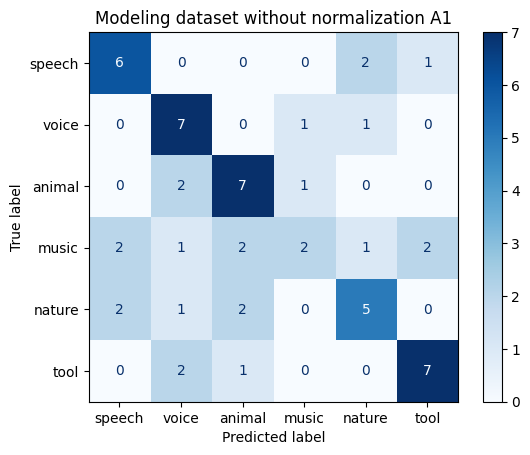

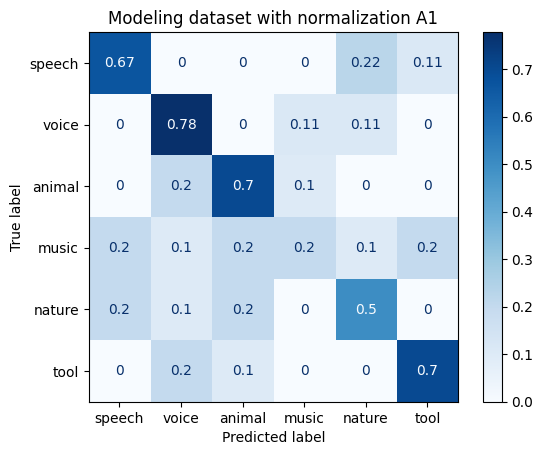

In [22]:
# Create a plot for the confusion matrix of the modeling dataset
titles_options_model = [
    ("Modeling dataset without normalization A1", None),
    ("Modeling dataset with normalization A1", "true"),
]
for title, normalize in titles_options_model:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_rf_modelA1, X_test_modelA1, y_test_modelA1,
        display_labels=class_names, cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    
    # Export the plot as a png file
    plt.savefig(f'Results/Confusion_matrix_{title.replace(" ", "_")}.png')

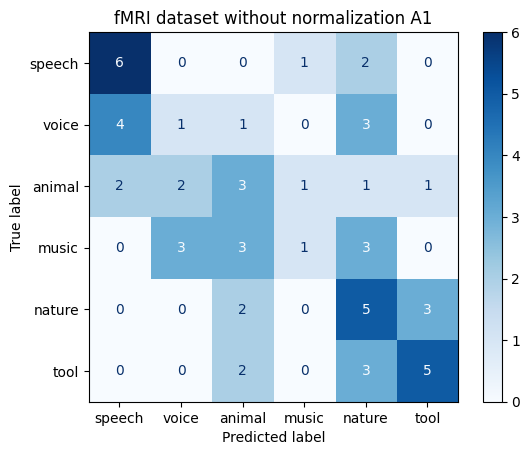

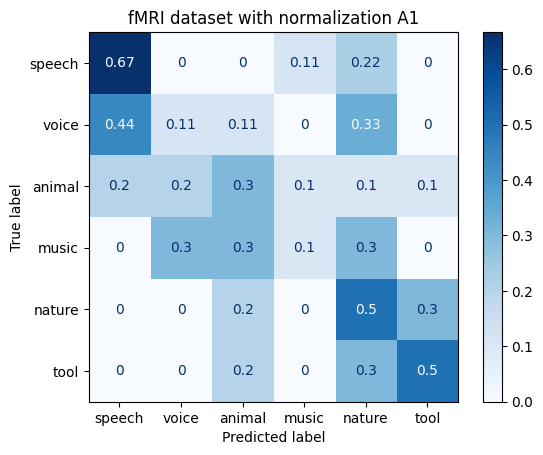

In [23]:
# Create a plot for the confusion matrix of the fmri dataset
titles_options_model = [
    ("fMRI dataset without normalization A1", None),
    ("fMRI dataset with normalization A1", "true"),
]
for title, normalize in titles_options_model:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_rf_fmriA1, X_test_fmriA1, y_test_fmriA1,
        display_labels=class_names, cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    
    # Export the plot as a png file
    plt.savefig(f'Results/Confusion_matrix_{title.replace(" ", "_")}.png')

#### **ROC curves**

In [24]:
# Calculate the y_score for the modeling and fMRI datasets
y_score_modelA1 = best_rf_modelA1.predict_proba(X_test_modelA1)
y_score_fmriA1 = best_rf_fmriA1.predict_proba(X_test_fmriA1)

# Binarize the outputs
y_test_bin_modelA1 = label_binarize(y_test_modelA1, classes=[0, 1, 2, 3, 4, 5])
y_test_bin_fmriA1 = label_binarize(y_test_fmriA1, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test_bin_modelA1.shape[1]

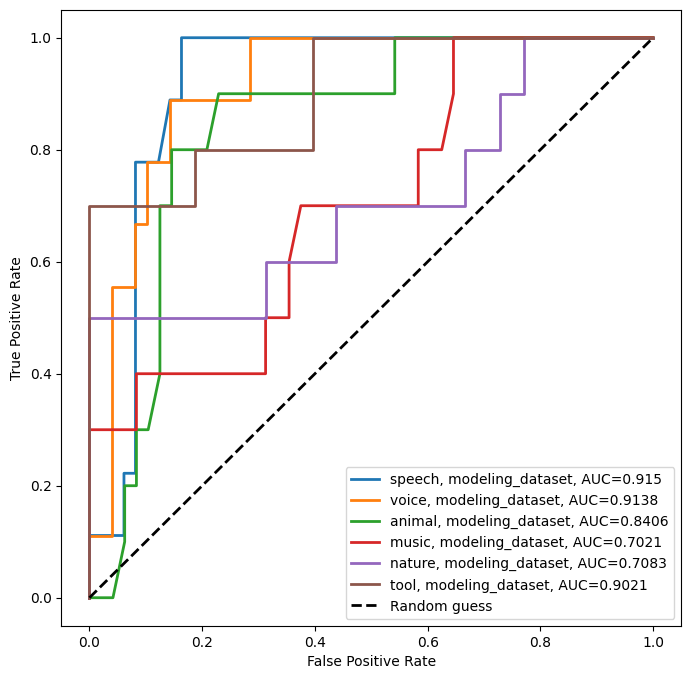

In [25]:
plt.figure(figsize=(8, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_modelA1[:, i], y_score_modelA1[:, i])
  auc = round(roc_auc_score(y_test_bin_modelA1[:, i], y_score_modelA1[:, i]), 4)
  plt.plot(fpr[i], tpr[i], lw=2, label= class_names[i] + ", modeling_dataset, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('Results/ROC_curve_bestmodel_modelingdataset_A1.png', bbox_inches='tight')

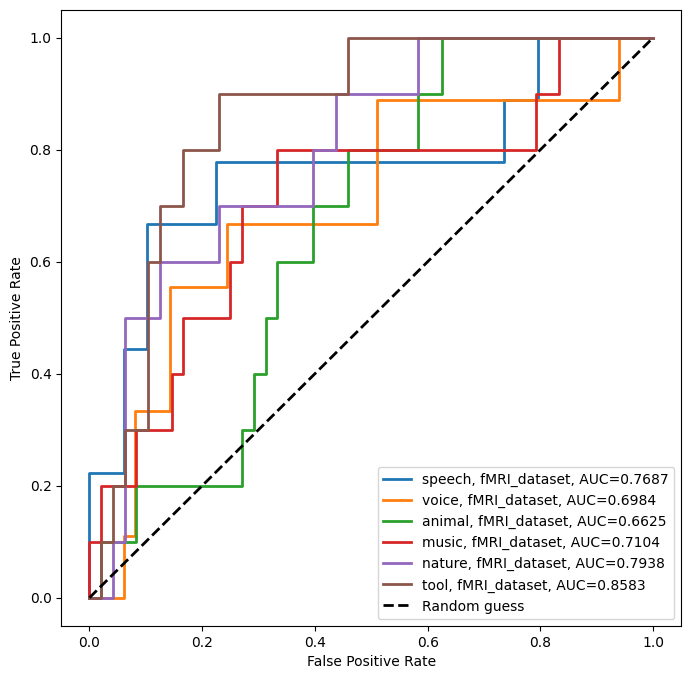

In [26]:
plt.figure(figsize=(8, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_fmriA1[:, i], y_score_fmriA1[:, i])
  auc = round(roc_auc_score(y_test_bin_fmriA1[:, i], y_score_fmriA1[:, i]), 4)
  plt.plot(fpr[i], tpr[i], lw=2, label= class_names[i] + ", fMRI_dataset, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('Results/ROC_curve_bestmodel_fmridataset_A1.png', bbox_inches='tight')

### **R**

In [31]:
# Dataset to store performance metrics of test dataset
results_bestmodels_testR = pd.DataFrame(index=range(6),columns=range(0))

# Create indice list
idxs = pd.Index(['Accuracy', 'Balanced accuracy', 'Precision', 
                'Recall', 'F1score', 'MCC'])
# Set indices
results_bestmodels_testR.set_index(idxs, inplace=True)

In [32]:
# Predicting values with the best model on test dataset
y_test_pred_modelR = best_rf_modelR.predict(X_test_modelR)
y_test_pred_fmriR = best_rf_fmriR.predict(X_test_fmriR)

# Calculate performance metrics of the modeling dataset
results_bestmodels_testR["RandomForest_modelingdataset_R"] = performance_metrics(y_test_modelR, y_test_pred_modelR)

# Calculate performance metrics of the fMRI dataset
results_bestmodels_testR["RandomForest_fmridataset_R"] = performance_metrics(y_test_fmriR, y_test_pred_fmriR)

In [33]:
# Show the final results
results_bestmodels_testR

,RandomForest_modelingdataset_R,RandomForest_fmridataset_R
Accuracy,0.586207,0.586207
Balanced accuracy,0.588889,0.585185
Precision,0.671630,0.580931
Recall,0.586207,0.586207
F1score,0.586013,0.565173
MCC,0.512176,0.509991


In [34]:
# Export results as a csv
results_bestmodels_testR.to_csv("Results/Results_best_classifiers_modeling_fmri_R_datasets.csv")

#### **Performance metrics for every class**

In [35]:
# List of class names
class_names = ["speech", "voice", "animal", "music", "nature", "tool"]

# Performance metrics per class of the best model on the modeling dataset
report_per_class_rf_modelR = classification_report(y_true=y_test_modelR, y_pred=y_test_pred_modelR,
                                                  target_names = class_names, digits=6, output_dict=True)

# Convert the dictionary to a dataframe
report_per_class_rf_model_dfR = pd.DataFrame(report_per_class_rf_modelR).transpose()

# Show the results
report_per_class_rf_model_dfR

,precision,recall,f1-score,support
speech,0.545455,0.666667,0.600000,9.000000
voice,0.500000,0.666667,0.571429,9.000000
animal,0.500000,0.700000,0.583333,10.000000
music,1.000000,0.300000,0.461538,10.000000
nature,0.454545,0.500000,0.476190,10.000000
tool,1.000000,0.700000,0.823529,10.000000
accuracy,0.586207,0.586207,0.586207,0.586207
macro avg,0.666667,0.588889,0.586003,58.000000
weighted avg,0.671630,0.586207,0.586013,58.000000


In [36]:
# Export results as a csv
report_per_class_rf_model_dfR.to_csv("Results/Performance_perclass_rf_modeldataset_R.csv")

In [37]:
# Performance metrics per class of the best model on the fMRI dataset
report_per_class_rf_fmriR = classification_report(y_true=y_test_fmriR, y_pred=y_test_pred_fmriR,
                                                target_names = class_names, digits=6, output_dict=True)

# Convert the dictionary to a dataframe
report_per_class_rf_fmri_dfR = pd.DataFrame(report_per_class_rf_fmriR).transpose()

# Show the results
report_per_class_rf_fmri_dfR

,precision,recall,f1-score,support
speech,0.615385,0.888889,0.727273,9.000000
voice,0.400000,0.222222,0.285714,9.000000
animal,0.666667,0.400000,0.500000,10.000000
music,0.700000,0.700000,0.700000,10.000000
nature,0.533333,0.800000,0.640000,10.000000
tool,0.555556,0.500000,0.526316,10.000000
accuracy,0.586207,0.586207,0.586207,0.586207
macro avg,0.578490,0.585185,0.563217,58.000000
weighted avg,0.580931,0.586207,0.565173,58.000000


In [38]:
# Export results as a csv
report_per_class_rf_fmri_dfR.to_csv("Results/Performance_perclass_rf_fmridataset_R.csv")

#### **Confusion matrices**

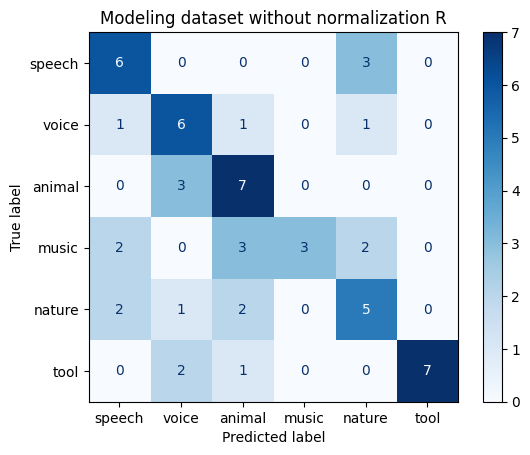

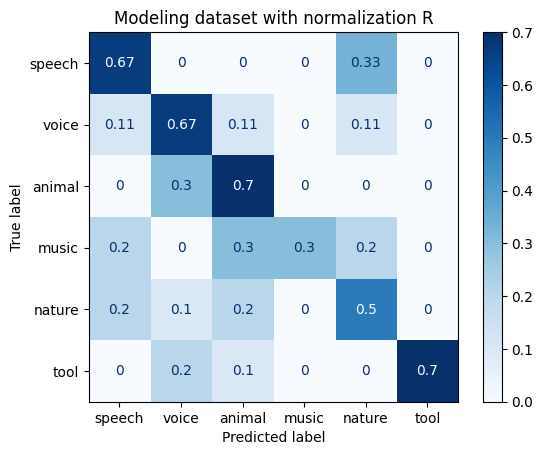

In [39]:
# Create a plot for the confusion matrix of the modeling dataset
titles_options_model = [
    ("Modeling dataset without normalization R", None),
    ("Modeling dataset with normalization R", "true"),
]
for title, normalize in titles_options_model:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_rf_modelR, X_test_modelR, y_test_modelR,
        display_labels=class_names, cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    
    # Export the plot as a png file
    plt.savefig(f'Results/Confusion_matrix_{title.replace(" ", "_")}.png')

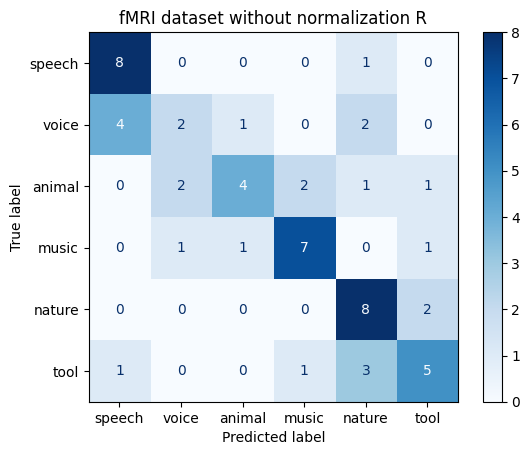

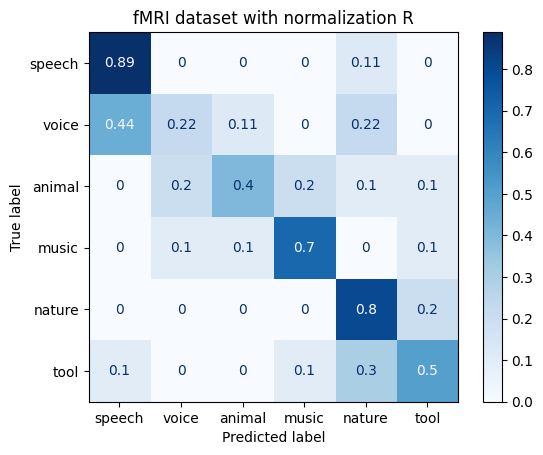

In [40]:
# Create a plot for the confusion matrix of the fmri dataset
titles_options_model = [
    ("fMRI dataset without normalization R", None),
    ("fMRI dataset with normalization R", "true"),
]
for title, normalize in titles_options_model:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_rf_fmriR, X_test_fmriR, y_test_fmriR,
        display_labels=class_names, cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    
    # Export the plot as a png file
    plt.savefig(f'Results/Confusion_matrix_{title.replace(" ", "_")}.png')

#### **ROC curves**

In [41]:
# Calculate the y_score for the modeling and fMRI datasets
y_score_modelR = best_rf_modelR.predict_proba(X_test_modelR)
y_score_fmriR = best_rf_fmriR.predict_proba(X_test_fmriR)

# Binarize the outputs
y_test_bin_modelR = label_binarize(y_test_modelR, classes=[0, 1, 2, 3, 4, 5])
y_test_bin_fmriR = label_binarize(y_test_fmriR, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test_bin_modelR.shape[1]

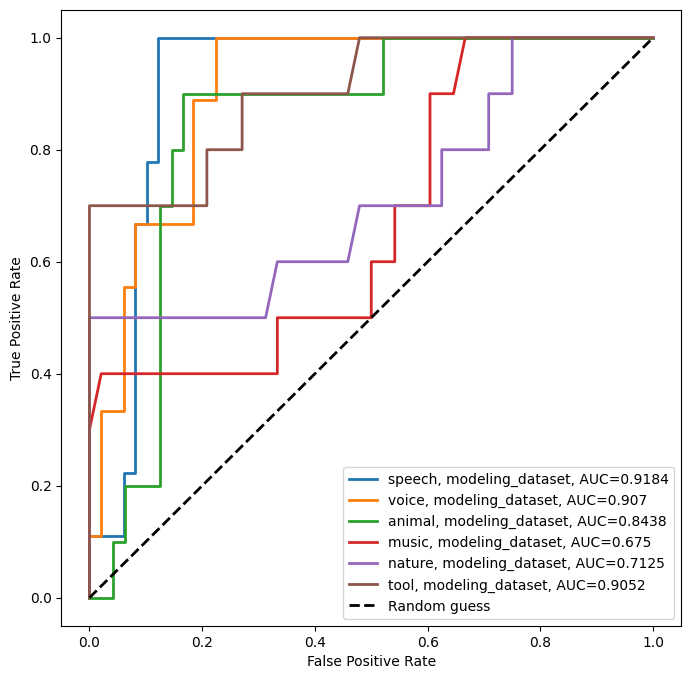

In [42]:
plt.figure(figsize=(8, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_modelR[:, i], y_score_modelR[:, i])
  auc = round(roc_auc_score(y_test_bin_modelR[:, i], y_score_modelR[:, i]), 4)
  plt.plot(fpr[i], tpr[i], lw=2, label= class_names[i] + ", modeling_dataset, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('Results/ROC_curve_bestmodel_modelingdataset_R.png', bbox_inches='tight')

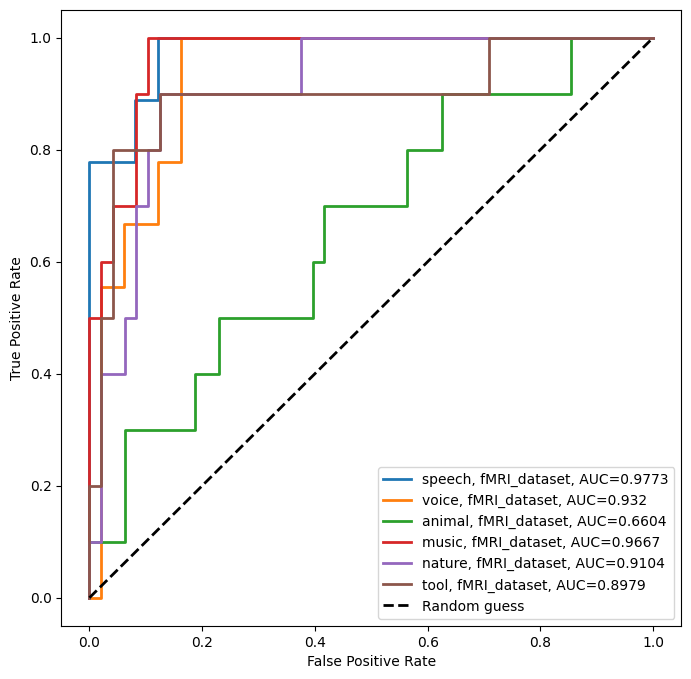

In [43]:
plt.figure(figsize=(8, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_fmriR[:, i], y_score_fmriR[:, i])
  auc = round(roc_auc_score(y_test_bin_fmriR[:, i], y_score_fmriR[:, i]), 4)
  plt.plot(fpr[i], tpr[i], lw=2, label= class_names[i] + ", fMRI_dataset, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('Results/ROC_curve_bestmodel_fmridataset_R.png', bbox_inches='tight')

### **S**

In [46]:
# Dataset to store performance metrics of test dataset
results_bestmodels_testS = pd.DataFrame(index=range(6),columns=range(0))

# Create indice list
idxs = pd.Index(['Accuracy', 'Balanced accuracy', 'Precision', 
                'Recall', 'F1score', 'MCC'])
# Set indices
results_bestmodels_testS.set_index(idxs, inplace=True)

In [47]:
# Predicting values with the best model on test dataset
y_test_pred_modelS = best_rf_modelS.predict(X_test_modelS)
y_test_pred_fmriS = best_rf_fmriS.predict(X_test_fmriS)

# Calculate performance metrics of the modeling dataset
results_bestmodels_testS["RandomForest_modelingdataset_S"] = performance_metrics(y_test_modelS, y_test_pred_modelS)

# Calculate performance metrics of the fMRI dataset
results_bestmodels_testS["RandomForest_fmridataset_S"] = performance_metrics(y_test_fmriS, y_test_pred_fmriS)

In [48]:
# Show the final results
results_bestmodels_testS

,RandomForest_modelingdataset_S,RandomForest_fmridataset_S
Accuracy,0.551724,0.689655
Balanced accuracy,0.553704,0.700000
Precision,0.566710,0.681034
Recall,0.551724,0.689655
F1score,0.555329,0.674700
MCC,0.462945,0.632556


In [49]:
# Export results as a csv
results_bestmodels_testS.to_csv("Results/Results_best_classifiers_modeling_fmri_S_datasets.csv")

#### **Performance metrics for every class**

In [50]:
# List of class names
class_names = ["speech", "voice", "animal", "music", "nature", "tool"]

# Performance metrics per class of the best model on the modeling dataset
report_per_class_rf_modelS = classification_report(y_true=y_test_modelS, y_pred=y_test_pred_modelS,
                                                  target_names = class_names, digits=6, output_dict=True)

# Convert the dictionary to a dataframe
report_per_class_rf_model_dfS = pd.DataFrame(report_per_class_rf_modelS).transpose()

# Show the results
report_per_class_rf_model_dfS

,precision,recall,f1-score,support
speech,0.666667,0.666667,0.666667,9.000000
voice,0.625000,0.555556,0.588235,9.000000
animal,0.461538,0.600000,0.521739,10.000000
music,0.333333,0.300000,0.315789,10.000000
nature,0.454545,0.500000,0.476190,10.000000
tool,0.875000,0.700000,0.777778,10.000000
accuracy,0.551724,0.551724,0.551724,0.551724
macro avg,0.569347,0.553704,0.557733,58.000000
weighted avg,0.566710,0.551724,0.555329,58.000000


In [51]:
# Export results as a csv
report_per_class_rf_model_dfS.to_csv("Results/Performance_perclass_rf_modeldataset_S.csv")

In [52]:
# Performance metrics per class of the best model on the fMRI dataset
report_per_class_rf_fmriS = classification_report(y_true=y_test_fmriS, y_pred=y_test_pred_fmriS,
                                                target_names = class_names, digits=6, output_dict=True)

# Convert the dictionary to a dataframe
report_per_class_rf_fmri_dfS = pd.DataFrame(report_per_class_rf_fmriS).transpose()

# Show the results
report_per_class_rf_fmri_dfS

,precision,recall,f1-score,support
speech,1.000000,1.000000,1.000000,9.000000
voice,0.750000,1.000000,0.857143,9.000000
animal,0.428571,0.300000,0.352941,10.000000
music,0.875000,0.700000,0.777778,10.000000
nature,0.571429,0.800000,0.666667,10.000000
tool,0.500000,0.400000,0.444444,10.000000
accuracy,0.689655,0.689655,0.689655,0.689655
macro avg,0.687500,0.700000,0.683162,58.000000
weighted avg,0.681034,0.689655,0.674700,58.000000


In [53]:
# Export results as a csv
report_per_class_rf_fmri_dfS.to_csv("Results/Performance_perclass_rf_fmridataset_S.csv")

#### **Confusion matrices**

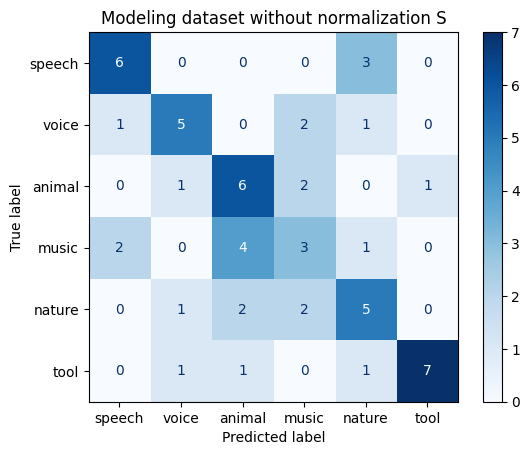

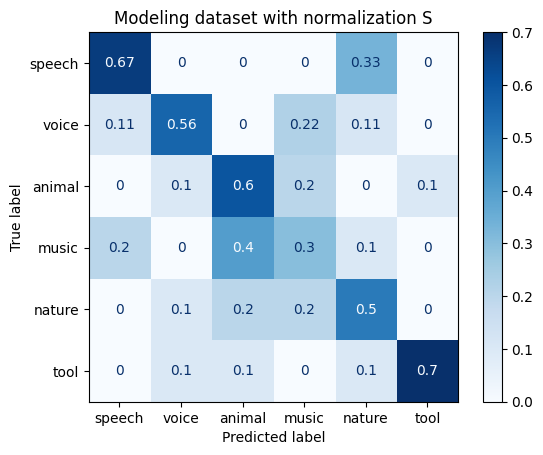

In [54]:
# Create a plot for the confusion matrix of the modeling dataset
titles_options_model = [
    ("Modeling dataset without normalization S", None),
    ("Modeling dataset with normalization S", "true"),
]
for title, normalize in titles_options_model:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_rf_modelS, X_test_modelS, y_test_modelS,
        display_labels=class_names, cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    
    # Export the plot as a png file
    plt.savefig(f'Results/Confusion_matrix_{title.replace(" ", "_")}.png')

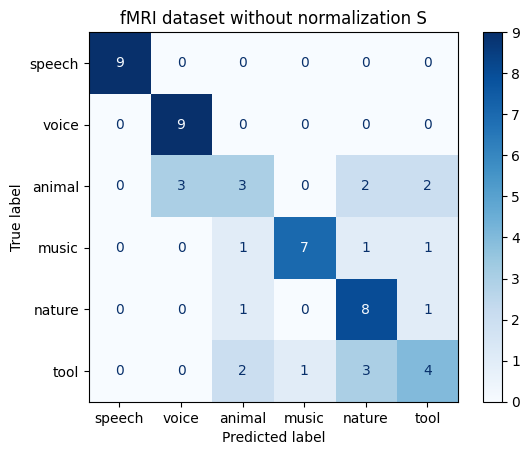

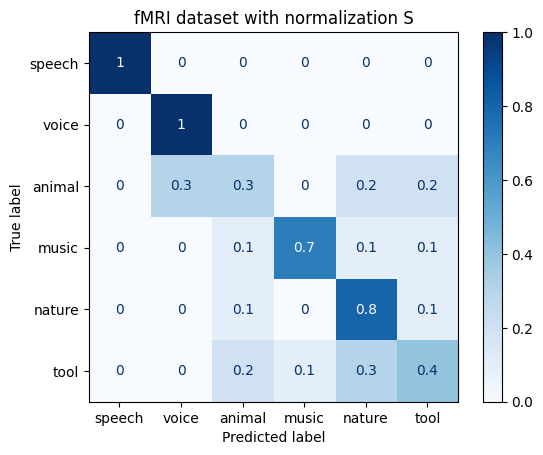

In [55]:
# Create a plot for the confusion matrix of the fmri dataset
titles_options_model = [
    ("fMRI dataset without normalization S", None),
    ("fMRI dataset with normalization S", "true"),
]
for title, normalize in titles_options_model:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_rf_fmriS, X_test_fmriS, y_test_fmriS,
        display_labels=class_names, cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    
    # Export the plot as a png file
    plt.savefig(f'Results/Confusion_matrix_{title.replace(" ", "_")}.png')

#### **ROC curves**

In [56]:
# Calculate the y_score for the modeling and fMRI datasets
y_score_modelS = best_rf_modelS.predict_proba(X_test_modelS)
y_score_fmriS = best_rf_fmriS.predict_proba(X_test_fmriS)

# Binarize the outputs
y_test_bin_modelS = label_binarize(y_test_modelS, classes=[0, 1, 2, 3, 4, 5])
y_test_bin_fmriS = label_binarize(y_test_fmriS, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test_bin_modelS.shape[1]

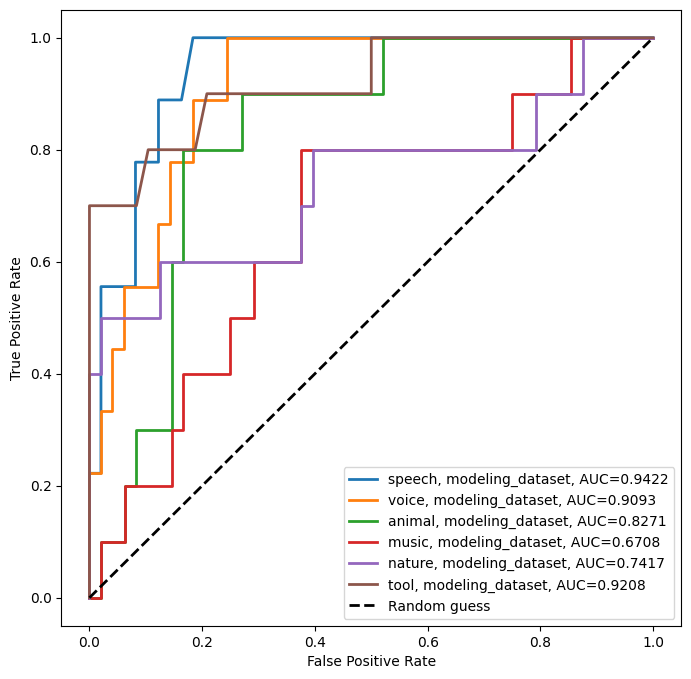

In [57]:
plt.figure(figsize=(8, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_modelS[:, i], y_score_modelS[:, i])
  auc = round(roc_auc_score(y_test_bin_modelS[:, i], y_score_modelS[:, i]), 4)
  plt.plot(fpr[i], tpr[i], lw=2, label= class_names[i] + ", modeling_dataset, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('Results/ROC_curve_bestmodel_modelingdataset_S.png', bbox_inches='tight')

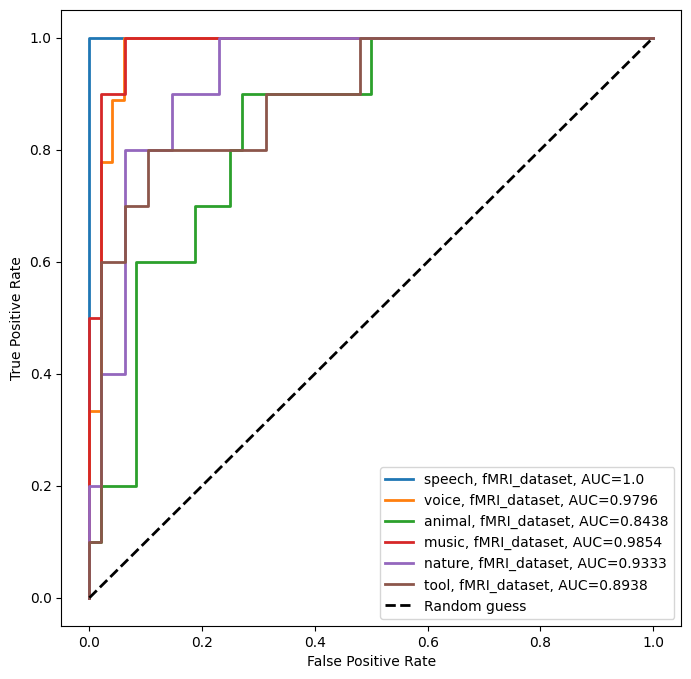

In [58]:
plt.figure(figsize=(8, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_fmriS[:, i], y_score_fmriS[:, i])
  auc = round(roc_auc_score(y_test_bin_fmriS[:, i], y_score_fmriS[:, i]), 4)
  plt.plot(fpr[i], tpr[i], lw=2, label= class_names[i] + ", fMRI_dataset, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('Results/ROC_curve_bestmodel_fmridataset_S.png', bbox_inches='tight')

### **F**

In [59]:
# Dataset to store performance metrics of test dataset
results_bestmodels_testF = pd.DataFrame(index=range(6),columns=range(0))

# Create indice list
idxs = pd.Index(['Accuracy', 'Balanced accuracy', 'Precision', 
                'Recall', 'F1score', 'MCC'])
# Set indices
results_bestmodels_testF.set_index(idxs, inplace=True)

In [60]:
# Predicting values with the best model on test dataset
y_test_pred_modelF = best_rf_modelF.predict(X_test_modelF)
y_test_pred_fmriF = best_rf_fmriF.predict(X_test_fmriF)

# Calculate performance metrics of the modeling dataset
results_bestmodels_testF["RandomForest_modelingdataset_F"] = performance_metrics(y_test_modelF, y_test_pred_modelF)

# Calculate performance metrics of the fMRI dataset
results_bestmodels_testF["RandomForest_fmridataset_F"] = performance_metrics(y_test_fmriF, y_test_pred_fmriF)

In [61]:
# Show the final results
results_bestmodels_testF

,RandomForest_modelingdataset_F,RandomForest_fmridataset_F
Accuracy,0.586207,0.448276
Balanced accuracy,0.590741,0.450000
Precision,0.595052,0.483353
Recall,0.586207,0.448276
F1score,0.582646,0.427860
MCC,0.506469,0.350626


In [62]:
# Export results as a csv
results_bestmodels_testF.to_csv("Results/Results_best_classifiers_modeling_fmri_F_datasets.csv")

#### **Performance metrics for every class**

In [63]:
# List of class names
class_names = ["speech", "voice", "animal", "music", "nature", "tool"]

# Performance metrics per class of the best model on the modeling dataset
report_per_class_rf_modelF = classification_report(y_true=y_test_modelF, y_pred=y_test_pred_modelF,
                                                  target_names = class_names, digits=6, output_dict=True)

# Convert the dictionary to a dataframe
report_per_class_rf_model_dfF = pd.DataFrame(report_per_class_rf_modelF).transpose()

# Show the results
report_per_class_rf_model_dfF

,precision,recall,f1-score,support
speech,0.750000,0.666667,0.705882,9.000000
voice,0.636364,0.777778,0.700000,9.000000
animal,0.500000,0.700000,0.583333,10.000000
music,0.400000,0.400000,0.400000,10.000000
nature,0.428571,0.300000,0.352941,10.000000
tool,0.875000,0.700000,0.777778,10.000000
accuracy,0.586207,0.586207,0.586207,0.586207
macro avg,0.598323,0.590741,0.586656,58.000000
weighted avg,0.595052,0.586207,0.582646,58.000000


In [64]:
# Export results as a csv
report_per_class_rf_model_dfF.to_csv("Results/Performance_perclass_rf_modeldataset_F.csv")

In [65]:
# Performance metrics per class of the best model on the fMRI dataset
report_per_class_rf_fmriF = classification_report(y_true=y_test_fmriF, y_pred=y_test_pred_fmriF,
                                                target_names = class_names, digits=6, output_dict=True)

# Convert the dictionary to a dataframe
report_per_class_rf_fmri_dfF = pd.DataFrame(report_per_class_rf_fmriF).transpose()

# Show the results
report_per_class_rf_fmri_dfF

,precision,recall,f1-score,support
speech,0.636364,0.777778,0.700000,9.000000
voice,0.666667,0.222222,0.333333,9.000000
animal,0.000000,0.000000,0.000000,10.000000
music,1.000000,0.600000,0.750000,10.000000
nature,0.277778,0.500000,0.357143,10.000000
tool,0.352941,0.600000,0.444444,10.000000
accuracy,0.448276,0.448276,0.448276,0.448276
macro avg,0.488958,0.450000,0.430820,58.000000
weighted avg,0.483353,0.448276,0.427860,58.000000


In [66]:
# Export results as a csv
report_per_class_rf_fmri_dfF.to_csv("Results/Performance_perclass_rf_fmridataset_F.csv")

#### **Confusion matrices**

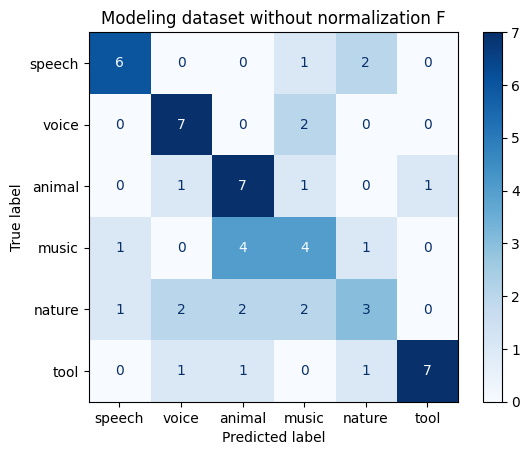

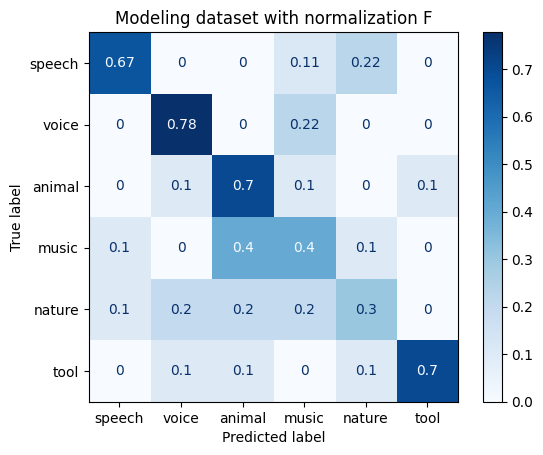

In [67]:
# Create a plot for the confusion matrix of the modeling dataset
titles_options_model = [
    ("Modeling dataset without normalization F", None),
    ("Modeling dataset with normalization F", "true"),
]
for title, normalize in titles_options_model:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_rf_modelF, X_test_modelF, y_test_modelF,
        display_labels=class_names, cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    
    # Export the plot as a png file
    plt.savefig(f'Results/Confusion_matrix_{title.replace(" ", "_")}.png')

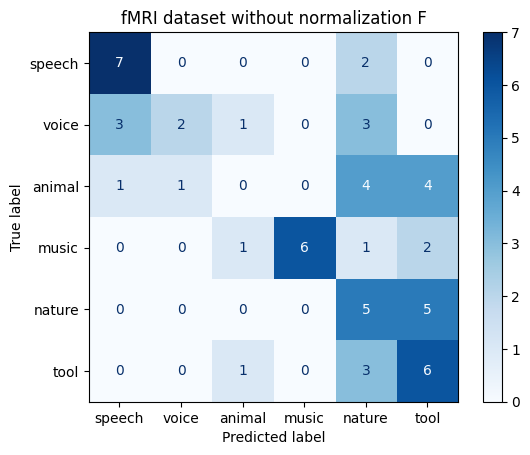

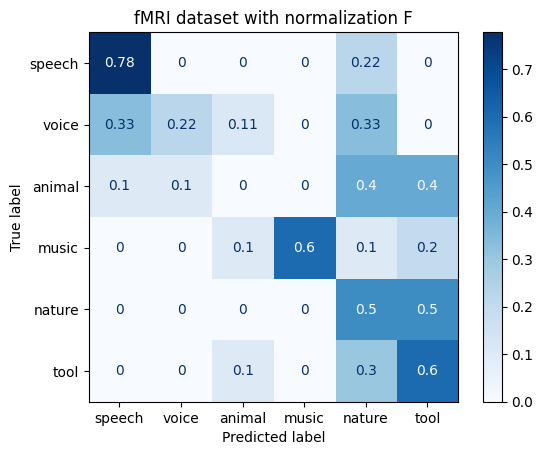

In [68]:
# Create a plot for the confusion matrix of the fmri dataset
titles_options_model = [
    ("fMRI dataset without normalization F", None),
    ("fMRI dataset with normalization F", "true"),
]
for title, normalize in titles_options_model:
    disp = ConfusionMatrixDisplay.from_estimator(
        best_rf_fmriF, X_test_fmriF, y_test_fmriF,
        display_labels=class_names, cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)
    
    # Export the plot as a png file
    plt.savefig(f'Results/Confusion_matrix_{title.replace(" ", "_")}.png')

#### **ROC curves**

In [69]:
# Calculate the y_score for the modeling and fMRI datasets
y_score_modelF = best_rf_modelF.predict_proba(X_test_modelF)
y_score_fmriF = best_rf_fmriF.predict_proba(X_test_fmriF)

# Binarize the outputs
y_test_bin_modelF = label_binarize(y_test_modelF, classes=[0, 1, 2, 3, 4, 5])
y_test_bin_fmriF = label_binarize(y_test_fmriF, classes=[0, 1, 2, 3, 4, 5])
n_classes = y_test_bin_modelF.shape[1]

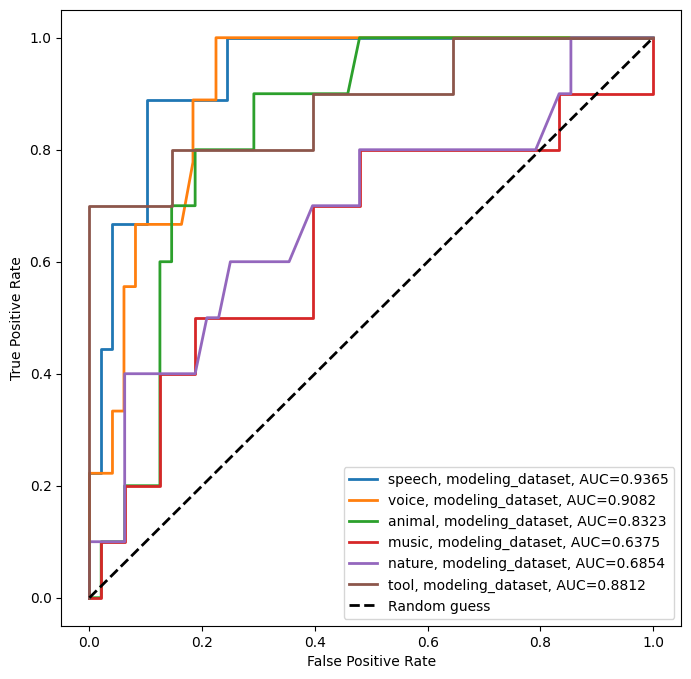

In [70]:
plt.figure(figsize=(8, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_modelF[:, i], y_score_modelF[:, i])
  auc = round(roc_auc_score(y_test_bin_modelF[:, i], y_score_modelF[:, i]), 4)
  plt.plot(fpr[i], tpr[i], lw=2, label= class_names[i] + ", modeling_dataset, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('Results/ROC_curve_bestmodel_modelingdataset_F.png', bbox_inches='tight')

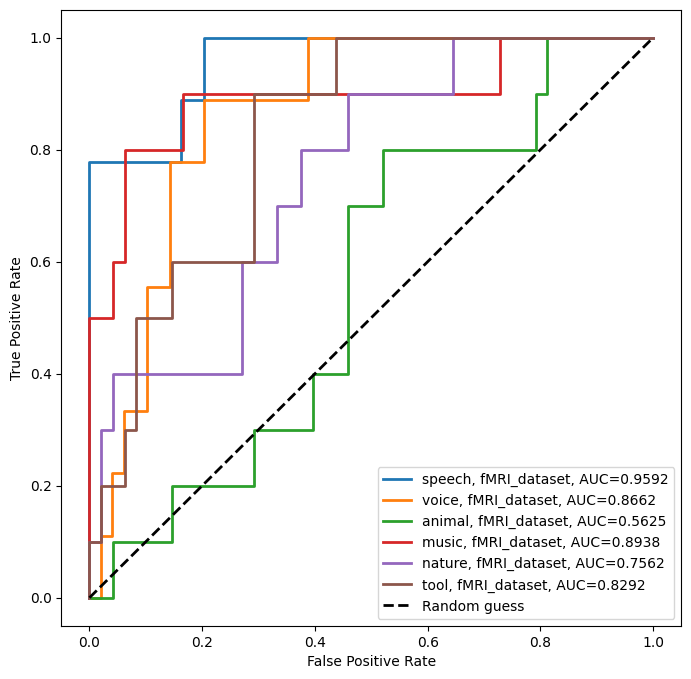

In [71]:
plt.figure(figsize=(8, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_fmriF[:, i], y_score_fmriF[:, i])
  auc = round(roc_auc_score(y_test_bin_fmriF[:, i], y_score_fmriF[:, i]), 4)
  plt.plot(fpr[i], tpr[i], lw=2, label= class_names[i] + ", fMRI_dataset, AUC="+str(auc))

plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Save the plot
plt.savefig('Results/ROC_curve_bestmodel_fmridataset_F.png', bbox_inches='tight')